In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import subprocess 
import matplotlib.pyplot as plt
import os
from copy import deepcopy
import galsim 
import corner 
import csv 

In [6]:
#directories that you would be using 
repo = '/Users/Ismael/code/lensing/SMFF'
os.chdir(repo)

In [7]:
#colormap default to use for galaxy 
cmap = 'RdYlGn'

In [8]:
def showImage(image,ax=None):
    if ax is None: 
        plt.imshow(image, cmap=cmap,vmax=abs(image).max(),vmin=-abs(image).max(),interpolation='None')
    else: 
        ax.imshow(image, cmap=cmap,vmax=abs(image).max(),vmin=-abs(image).max(),interpolation='None')

## Analysis of a single galaxy

### Generating a galaxy file

In [9]:
#parameters of galaxy to draw. 
model = 'gaussian' #possible options of model and psf_model are in documentation. 
psf_model = 'psf_gaussian'
e1 = .2
e2 = .2 
hlr = .5 
psf_fwhm = .7
snr = 20.
x0 = 1. 
y0 = 1. 

#project folder name where you want to write galaxy information 
project = 'project-tutorial-fits'

In [ ]:
cmd = 'python generate.py -p {0} -gal 1 --galaxy-model {1} --psf_model {2}  --e1 {3} --e2 {4} --x0 {5} --y0 {6}  \
--flux 1. --psf_flux 1. --hlr {7} --psf_fwhm {8} --snr {9}'.format(project,model,psf_model,e1,e2,x0,y0,hlr,psf_fwhm,snr)
output = subprocess.check_output(cmd, shell=True)
print output

### Get fisher formalism analysis from the file

In [10]:
import analysis.fisher as fisher 
import analysis.galfun as galfun
import analysis.defaults as defaults 

In [11]:
g_parameters = galfun.GParameters(project) #extract parameters from file created by generate.py 
image_renderer = galfun.ImageRenderer(pixel_scale=defaults.PIXEL_SCALE,nx=defaults.NX,ny=defaults.NY)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, snr=snr)

### Draw the galaxy generated 

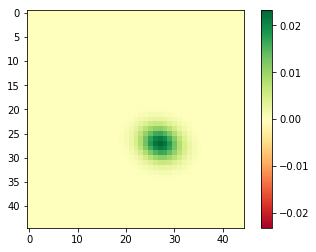

In [11]:
#get galaxy image and display it from fisher object. green is positive and red is negative 
showImage(fish.image.array)
plt.colorbar()

### Do the fits 

In [12]:
#using lm does a fitting to number_fits noise realizations of the galaxy above 
#produces a file for each of the fittings in the given project folde.r 
number_fits = 10000

In [ ]:
#this is the cmd for local (but will take a long time)
cmd_local = 'python fitting.py -p {0} --snr {1} -n {2} -rf'.format(project,snr,number_fits)

#and for a SLAC computer. 
cmd_slac = 'python fitting.py -p {0} --snr {1} -n {2} -rfs short'.format(project,snr,number_fits)

#
print cmd_local
print cmd_slac

In [13]:
#constants needed for the plots below 
EXTENT_PULL = (-3, 3)
BINS_PULL = 40
SIG_DIGITS = 4

### Process results from fits files 

In [14]:
%%capture
pulls,residuals,biases,pull_means,res_stds,pull_mins,pull_maxs,redchis = galfun.read_results(project,g_parameters,fish)


### Produce image with fisher 68% prediction 

In [27]:
def errorEllipseCor(centroid, cor_xy, alpha=1.52):
    """
    Return a correlation ellipse according to Dan Coe paper arxiv.0906.4123.

    We use correlations instead of covariances for the ellipses because most of
    the parameters in our models have dimensions.
    Confidence level by default is 68.3% -> alpha = 1.52 according to the same
    paper.

    Args:
        centroid(:py:tuple): Position of the center of the ellipse in
                             (x,y) form.

    Returns:
        An mpatch.Ellipse object
    """
    import matplotlib.patches as mpatch

    a = 1 + cor_xy
    b = 1 - cor_xy
    theta = 45
    width = 2 * alpha * a
    height = 2 * alpha * b

    ellipse = mpatch.Ellipse(xy=centroid, width=width, height=height,
                             angle=theta, edgecolor='r', fc='None', lw=2)

    return ellipse

In [38]:
def fisher_prediction(params,bound_mins,bound_maxs,fish,number_fits):
    """Draws a triangle shaped plot with the fisher prediction for 68% confidence level"""

    fish_figure = plt.figure(figsize=(11, 11)) #this is the figure containing the fisher predictions. 
    normalized_area = (EXTENT_PULL[1] - EXTENT_PULL[0]) * (number_fits / BINS_PULL)
    param_names = fish.param_names
    num_params = len(params)
    color_hist = 'blue'
    for param in params:
        # produce pull plot.

        dim = num_params + 1  # for redchi add extra dimension.


        #here we create our triangle. 
        for i in range(dim):
            for j in range(dim):
                if i < num_params and j < num_params and i >= j:
                    param_i = param_names[i]
                    param_j = param_names[j]
                    sigma_i = math.sqrt(fish.covariance_matrix[param_i,param_i])
                    sigma_j = math.sqrt(fish.covariance_matrix[param_j, param_j])
                    mean = (fish.biases[param_i] / sigma_i,fish.biases[param_j] / sigma_j)
                    cor_xy = fish.correlation_matrix[param_i, param_j]

                    if i == j:
                        sigma_gauss = 1 #normalize normal pdf.
                        x = np.linspace(EXTENT_PULL[0], EXTENT_PULL[1], 1000)
                        ax = fish_figure.add_subplot(dim, dim, dim * i + j + 1)
                        ax.plot(x, normalized_area * mlab.normpdf(x, mean[0],sigma_gauss),color=color_hist)
                        sigma_fisher = round(sigma_i, SIG_DIGITS)
                        sigma_fits = round(res_stds[param_i], SIG_DIGITS)

                        #error of bias_fits
                        sigma_1 = round(sigma_fits / math.sqrt(number_fits),SIG_DIGITS)
                        #error of sigma_fits
                        sigma_2 = round(sigma_fits / math.sqrt(2*number_fits), SIG_DIGITS)
                        bias_fisher = round(fish.biases[param_i],SIG_DIGITS)
                        bias_fits = round(biases[param_i],SIG_DIGITS)

                        data = (
                              r'\begin{eqnarray*}' +
                              r'\sigma_{F}' + '& = &' +
                              str(sigma_fisher) +
                              r'\\' +
                              r'\sigma_{fits}' + '& = &' +
                              str(sigma_fits) +
                              r'\pm' +
                              str(sigma_2) +
                              r'\\' +
                              r'b_{F}' + '& = &' +
                              str(bias_fisher) +
                              r'\\' +
                              r'b_{fits}' + '& = &' +
                              str(bias_fits) +
                              r'\pm' +
                              str(sigma_1) +
                              r'\end{eqnarray*}')


                        ax.text(1.715, .35, data,
                                transform=ax.transAxes, ha='center',
                                fontsize=10,
                                fontweight='bold')

                        # add green lines indicating bounds.
                        ax.axvline(x=pull_mins[param_j], color='g')
                        ax.axvline(x=pull_maxs[param_j], color='g')

                    elif i > j:
                        # draw an error_ellipse in off-diagonals axises.
                        ellip = errorEllipseCor(mean, cor_xy)
                        ax = fish_figure.add_subplot(dim, dim,
                                                     dim * i + j + 1)
                        ax.add_patch(ellip)

                        ax.axhline(y=pull_mins[param_i], color='g')
                        ax.axhline(y=pull_maxs[param_i], color='g')
                        ax.axvline(x=pull_mins[param_j], color='g')
                        ax.axvline(x=pull_maxs[param_j], color='g')

                else:
                    ax = fish_figure.add_subplot(dim,
                                                 dim,
                                                 dim * i + j + 1)
    plt.rc('text', usetex=True)
    return fish_figure

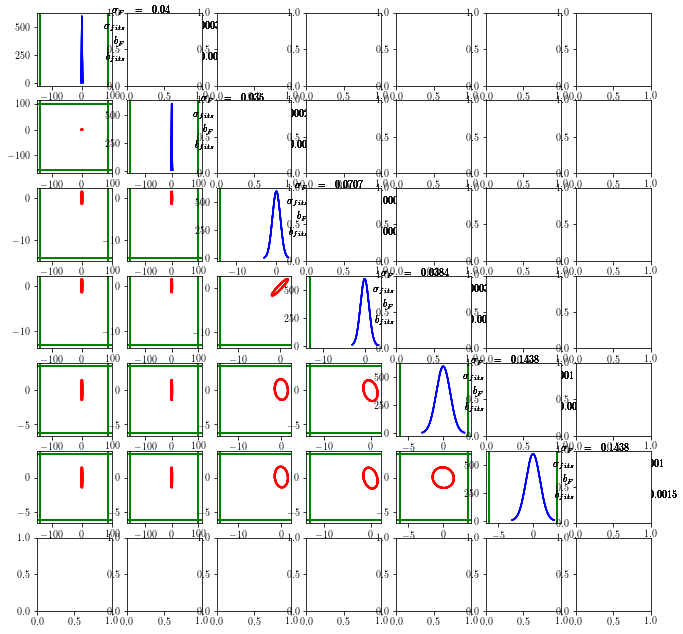

In [39]:
fish_figure = fisher_prediction(pulls.keys(),pull_mins,pull_maxs,fish,number_fits)

### Produce corner plot with fits results. 

In [40]:
def fit_plots(pulls,pull_mins,pull_maxs,redchis,fish,fish_figure=None):
    """Draws a triangle plot with fisher predictions overalayed and the results from the fittings."""
    param_names = fish.param_names
    num_params = fish.num_params

    # have to transform point.values to a convenient form for the plot.
    extents = [EXTENT_PULL] * num_params + [(min(redchis),max(redchis))]
    points_plot = []
    truths = []
    plot_names = []

    for param in param_names:
        if 'e1' in param:
            tex_param = r'$e_{1}$'
        elif 'e2' in param:
            tex_param = r'$e_{2}$'
        elif 'x0' in param:
            tex_param = r'$x_{0}$'
        elif 'y0' in param:
            tex_param = r'$y_{0}$'
        else:
            new_param = param.replace('_1', '')
            tex_param = r'$' + new_param + r'$'
        plot_names.append(tex_param)

    plot_names.append(r'$\chi^{2}/dof$')

    for param in param_names:
        points_plot.append(pulls[param])
        truths.append(pull_means[param])

    #chi2, redchi should be centered around 1
    truths.append(1)
    points_plot.append(redchis)
    
    hist2d_kwargs = {'plot_datapoints':True,'plot_density':False,'plot_contours':False, 'no_fill_contours':False,'fill_contours':False}
    #here we overlay the produced fish_figure and the triangle plot. 
    figure1 = corner.corner(np.array(points_plot).transpose(),
                              bins=BINS_PULL,
                              labels=plot_names,
                              extents=extents,
                              truths=truths,
                              show_titles=True,
                              title_fmt=None, 
                              title_kwargs={"fontsize": 12},label_kwargs=None,
                              fig=fish_figure,hist_kwargs=None,**hist2d_kwargs)

    figure1.subplots_adjust(hspace=.2, wspace=.2) #adjust to avoid overlap.
    figure1.savefig(os.path.join(project, 'triangle.pdf'))
    print os.path.join(project, 'triangle.pdf')
    plt.rc('text', usetex=True)

In [41]:
 #figure is saved in project folder because of its complexity. 
fit_plots(pulls,pull_mins,pull_maxs,redchis,fish,fish_figure=fish_figure)

project-tutorial-fits/triangle.pdf


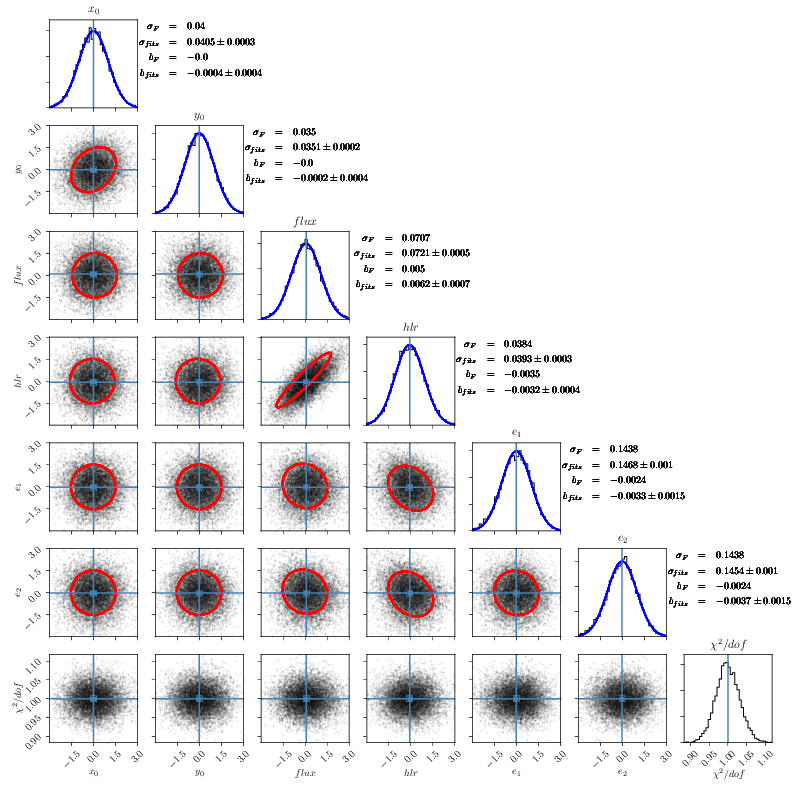

In [42]:
from wand.image import Image as WImage
img = WImage(filename='project-tutorial-fits/triangle.pdf')
img

### Chi2 Histogram from data 

In [23]:
def chi2_histogram(redchis):
    # produce redchi individual histogram
    figure2 = plt.figure()
    ax = figure2.add_subplot(111)
    ax.hist(redchis,bins=40,histtype='step')
    ax.set_title('Reduced chi2 histogram from data.',
                 fontsize=18)

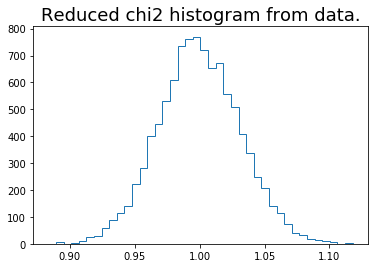

In [24]:
chi2_histogram(redchis)